# 종합실습2
# 분석 배경
### OO공장의 고객사에서 최근 들어 "Scale 불량 발생 증가"라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale 불량이 급증한 것을 확인할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 개선을 위한 최적의 조건을 도출하고자 한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
# 다중공선성 패키지 불러오기
from statsmodels.stats.outliers_influence import variance_inflation_factor
# sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.linear_model import LinearRegression
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE
# 데이터 scale
from sklearn.preprocessing import scale

In [2]:
ds = pd.read_excel("./실습파일/빅데이터분석.xlsx", sheet_name="종실2.SCALE불량")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
PLATE_NO             720 non-null object
ROLLING_DATE         720 non-null object
SCALE                720 non-null object
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null object
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(12), object(8)
memo

### 데이터 자체에 결측치가 없다.

### PLATE_NO와 ROLLING_DATE는 식별용이라 제거하고 분석한다.

In [3]:
ds = ds.drop(["PLATE_NO","ROLLING_DATE"], axis = 1)

In [5]:
ds.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


(720, 19)

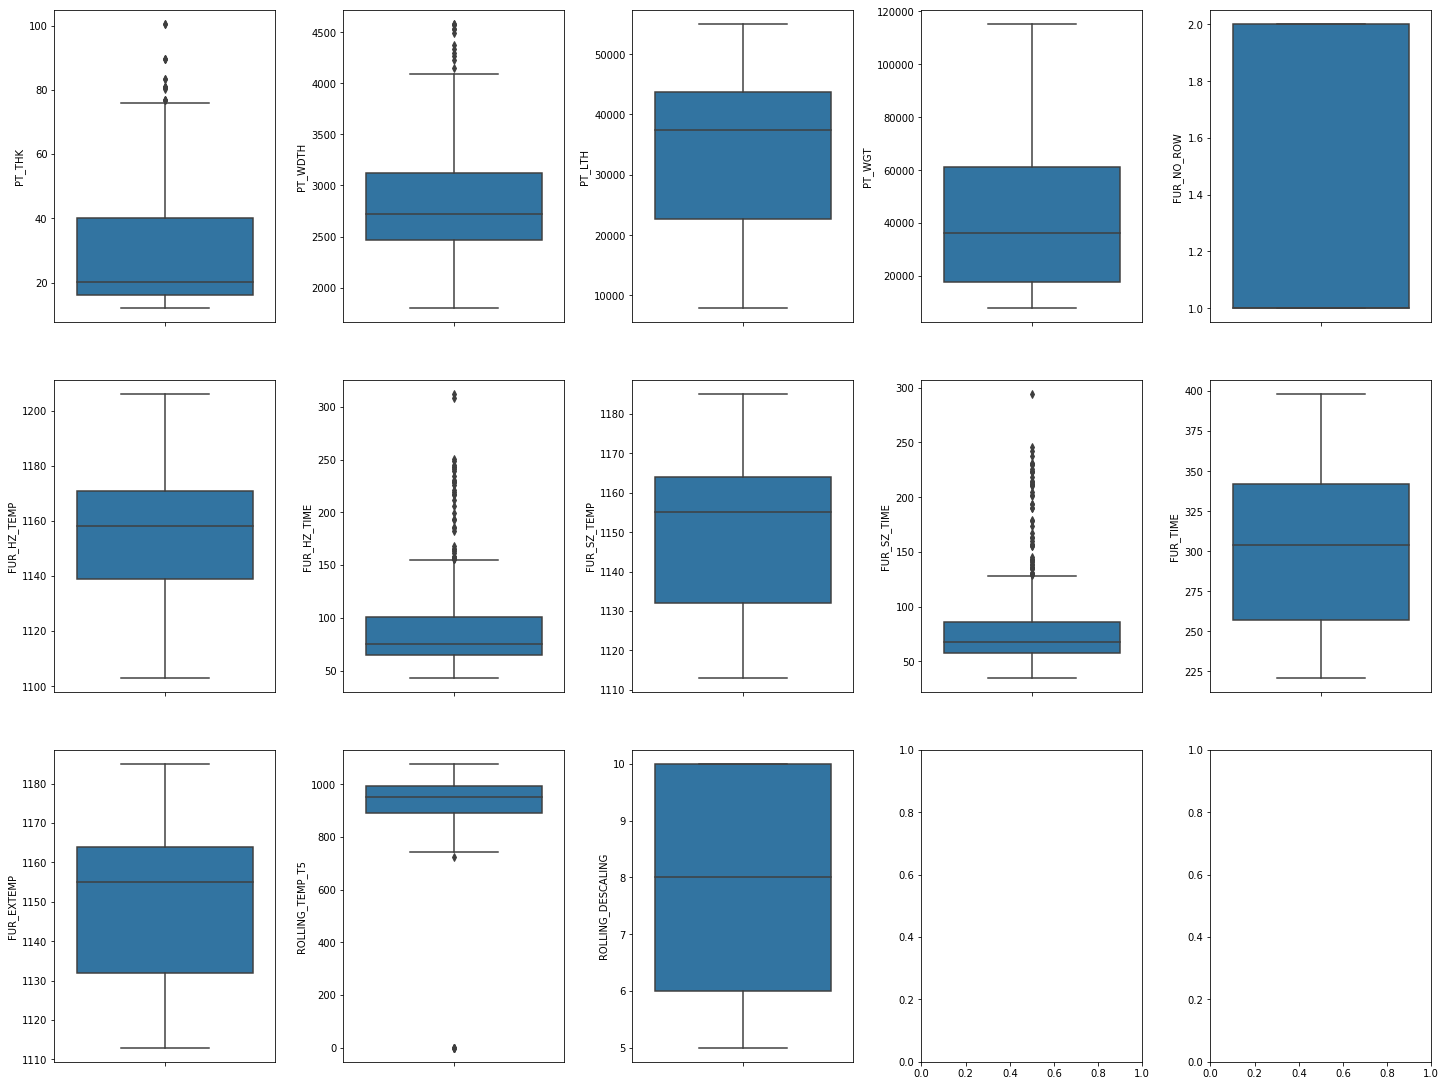

In [6]:
ds_num = ds.select_dtypes(exclude = 'object')
fig, axs = plt.subplots(ncols=5, nrows=3, figsize = (20,15))
index = 0
axs = axs.flatten()
for k,v in ds_num.items():
    sns.boxplot(y=k, data=ds_num, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
ds.shape

### ROLLING_TEMP_T5에 이상치(온도가 0인 데이터)가 있다. 제거해야함.

In [7]:
df_filtered = ds[(ds["ROLLING_TEMP_T5"] < 100)]
df_filtered

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
41,양품,GL-E36-TM,T8,55.51,3765,11398,37400,3호기,2,1132,95,1128,80,341,1128,0,적용,6,1조
184,양품,JS-SM490YB,C0,16.09,2221,43596,61150,3호기,1,1169,64,1164,61,308,1164,0,적용,10,3조
185,양품,JS-SM490YB,C0,16.09,2221,43596,61150,3호기,2,1163,57,1166,67,303,1166,0,적용,10,4조
494,양품,PILAC-BT33,T5,80.82,2085,12919,17090,2호기,1,1133,89,1122,59,378,1122,0,적용,6,2조
495,양품,PILAC-BT33,T5,80.82,2085,13176,17430,1호기,2,1130,92,1124,61,362,1124,0,적용,6,3조
496,양품,NV-D32-TM,T0,40.35,2497,23592,37320,3호기,1,1119,109,1117,76,383,1117,0,적용,6,3조


In [8]:
ds = ds[ds["ROLLING_TEMP_T5"] >= 100]
ds.shape

(714, 19)

### 이상치 6개 제거 완료(원래 행렬크기 (720, 19))

In [10]:
print(pd.Series(ds["SPEC"], dtype = "category").cat.categories.shape)
print(pd.Series(ds["STEEL_KIND"], dtype = "category").cat.categories.shape)
# 이 이외의 나머지 변수들은 범주가 4개 이하

(66,)
(9,)


### 설명변수 SPEC의 category가 너무 많은 것 같아 뽑아보니 66개가 있음. 
### 어떻게 처리할까 고민해 봐야함.
### 이 과정 다음엔 Y(목표변수)와 Xs(설명변수들)을 분리하고 범주형 설명변수를 dummy화 해야함.
### 더미화 해야할 변수가 너무 많다. 하지만 더미화해서 보자!

### 설명변수 SCALE -> 양품 = 0, 불량 = 1
### 설명변수 HSB -> 적용 = 1, 미적용 = 0

In [11]:
ds["SCALE"].replace(to_replace = "양품", value = 0, inplace = True)
ds["SCALE"].replace(to_replace = "불량", value = 1, inplace = True)
ds["HSB"].replace(to_replace = "미적용", value = 0, inplace = True)
ds["HSB"].replace(to_replace = "적용", value = 1, inplace = True)

##### A131과 DH36강은 배의 선체를 만드는 강
##### ABS는 미국의 선급협회 AB(S)/“A”는 상온에서(20℃), “B”는 0℃, “D”로 표기되면 -20℃, “E”는 -40℃에서의 충격시험을 하라는 의미입니다.
##### BV-A,B,E GL-A,D,E
#### JS-S / KR-A,B / KS-H,S / LR-A,B,E / NK-K / NV-A,B,D,E
#### MTO(Make To Order) 방식

In [12]:
ds_dummy = pd.get_dummies(ds)
ds_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,...,STEEL_KIND_T5,STEEL_KIND_T7,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,...,0,0,0,1,0,0,0,1,0,0
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,...,0,0,0,1,0,0,0,1,0,0
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,...,0,0,1,0,1,0,0,0,1,0
3,0,33.27,3619,19181,18130,2,1152,125,1127,68,...,0,0,1,0,1,0,0,0,1,0
4,0,38.33,3098,13334,12430,1,1140,134,1128,48,...,0,0,1,0,0,1,1,0,0,0
